# Homework 1   - Javier Garcia Ordonez - 100345713

----------------------------------------------------
Machine Learning                      

Year 2019/2020

*Vanessa Gómez Verdejo vanessa@tsc.uc3m.es* 

----------------------------------------------------

The goal of this practice is to analyze the performance of different estimators on the Diabetes problem and we will analyze, by means of different approximations, which input features are more relevant to solve this problem. 

Note that previous week we already worked on Diabetes database, but we only used one of the input variable (BMI) to construct the regression model; in this practice we will use all the input features jointly.

To solve these notebook, complete the following sections implementing the solution that you consider most appropriate and showing the results that you find most interesting. For the evaluation of this notebook,  we will take into account the methodology used, the solution adopted, the presentation of the results and the conclusions obtained at the light of the results.


## 1. Data loading and preprocessing

Following the ML pipeline, start loading the data, creating the partitions that you consider necessary and carrying out the preprocessing that you need.

Keep in mind that there is no single valid solution, and different reasons can lead you to make different data partitions or apply different normalizations. So **please justify the steps you are taking**.

In [1]:
# Data loading and preprocessing

# Import necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# Load the diabetes dataset
diabetes = load_diabetes()
X = diabetes.data
Y = diabetes.target
feature_names = diabetes.feature_names

Data is to be partitioned into training and test data (80%-20% respectively). No validation set is to be generated as later we will be using cross-validation with the function GridSearchCV, which performs the training-validation partition by itself.

Then, both data partitions are normalized.

In [64]:
# Generate train and test partitions
import random
random.seed(42)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=25)

# Data normalization
transformer = StandardScaler().fit(X_train)  # fit() learns mean and std parameters
X_train = transformer.transform(X_train) # transform() normalizes
X_test =  transformer.transform(X_test)

**Note**: it has been observed that changing the random_state of the train_test_split function (or eliminating it, letting it random) greatly changes the test scores yielded, and sometimes the choice of the hyperparameters. This makes sense, as our database only contains 442 data points, and therefore which ones we include in the test and training sets affects the results. 

There is little we can do about it. To make results reproducible, the random seed has been fixed, and the random_state is also set to a fixed value (0).

## 2. Performance evaluation 

Now, analyze the performance of different estimators to predict the diabetes progression from all the available features. 

As possible estimators to be included in this study, we will consider those studied so far: K-NN, linear regressor, polynomial regressor and their regularized versions. Please, in case these methods have any free hiperparameter, **clearly justify** the selection of their optimal values.

As you know, for the performance evaluation, we have seen several metrics. So, here, you can use one or several of them. But, regardless of the used metric, don't forget to include a final analysis comparing the performance of different methods and trying to justify the obtained results.

### 2.0 Score
For evaluation of all the methods, R2 score is going to be used. It is the most used metric, as it is easy to interpret: 1.00 would mean no error; 0.00 would mean predicting always the mean, and negative would be performing even worse.

### 2.1 K-NN
First of all, let's use the K-NN estimator in order to try to predict disease progression

As we have a free hyperparameter, **k** (the number of neighbors), we need to cross-validate it. For cross-validation, the function GridSearchCV is going to be used.

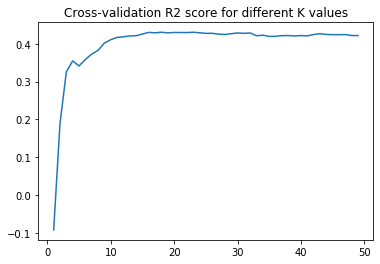

The optimal k value is 23


In [66]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

# Create a KNN object from th SKlearn module
neigh = KNeighborsRegressor()  

# Perform a Cross-Validation in order to choose the hiperparameter K
rang_k = np.arange(1,50)
parameters = {'n_neighbors' : rang_k}
clf = GridSearchCV(neigh,parameters,iid=False,cv=10, scoring = 'r2')
clf.fit(X_train,Y_train) # this executes the cross-validation

# Visualize the results of CrossValidation
plt.figure()
plt.plot(rang_k, clf.cv_results_['mean_test_score'])
plt.title('Cross-validation R2 score for different K values')
plt.show()

optimk = clf.best_params_['n_neighbors']
print('The optimal k value is %d' %optimk)

# The KNN estimator, already trained with the optimal K and fitted to our data
neigh = clf.best_estimator_

In [67]:
# Let's now evaluate the performance of the KNN regressor over the test data
from sklearn.metrics import r2_score

knn_prediction = neigh.predict(X_test)
knn_score = r2_score(Y_test,knn_prediction)
print('The test R2 score of the KNN method is %.3f' %knn_score)

The test R2 score of the KNN method is 0.403


### 2.2. Linear regressor (and regularized versions)
The linear regressor has a unique solution. No hyperparameters are needed. 

Nevertheless, we can include L1 (Lasso), L2 (Ridge) regularization in order to avoid overfitting, due to very large values of some of the weights. Both regularization techniques have an hyperparameter $\alpha$ which should be cross validated. Also, we can use ElasticNet, which combines both L1 and L2 regularizations. It is necessary to cross-validate two hyperparameters, $\alpha$ and the ratio of L1/L2 regularization.

In [94]:
import sklearn.linear_model as ln

# Let's train several different linear regressors, and find their score

# Ordinary least squares linear regression
linear = ln.LinearRegression(fit_intercept=True).fit(X_train,Y_train)
linear_prediction = linear.predict(X_test)
linear_score = r2_score(Y_test,linear_prediction)
print('Linear regressor :')
print('\tTrain R2 score %.3f. Test R2 score %.3f.' %(linear.score(X_train,Y_train),linear.score(X_test,Y_test)))


# Lasso. Needed to cross-validate alpha
lasso = ln.Lasso(fit_intercept=True)
rang_alpha = [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]
parameters = {'alpha': rang_alpha}
clf = GridSearchCV(lasso,parameters,iid=False,cv=10, scoring= 'r2')
clf.fit(X_train,Y_train)
lasso = clf.best_estimator_
lasso_prediction = lasso.predict(X_test)
lasso_score = r2_score(Y_test,lasso_prediction)
print('Lasso regressor with \u03B1 = %.3f :' %(clf.best_params_['alpha']))
print('\tTrain R2 score %.3f. Test R2 score %.3f.' %(lasso.score(X_train,Y_train),lasso.score(X_test,Y_test)))

# Ridge. Needed to cross-validate alpha
rang_alpha = [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]
parameters = {'alpha' : rang_alpha}
clf = GridSearchCV(ln.Ridge(fit_intercept=True),parameters,iid=False,cv=10, scoring= 'r2')
clf.fit(X_train,Y_train)
ridge = clf.best_estimator_
ridge_prediction = ridge.predict(X_test)
ridge_score = r2_score(Y_test,ridge_prediction)
print('Ridge regressor with \u03B1 = %.3f :' %(clf_ridge.best_params_['alpha']))
print('\tTrain R2 score %.3f. Test R2 score %.3f.' %(ridge.score(X_train,Y_train),ridge.score(X_test,Y_test)))

# ElasticNet. Needed to cross-validate alpha
rang_alpha = [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]
ratio = np.arange(0.1,1,0.1)
parameters = {'alpha' : rang_alpha, 'l1_ratio':ratio}
clf = GridSearchCV(ln.ElasticNet(fit_intercept=True,max_iter=1000000),parameters,iid=False,cv=10, scoring= 'r2')
clf.fit(X_train,Y_train)
elasticnet = clf.best_estimator_
elasticnet_prediction = elasticnet.predict(X_test)
elasticnet_score = r2_score(Y_test,elasticnet_prediction)
print('ElasticNet regressor with \u03B1 = %.3f and ratio %.1f.' %(clf_elasticnet.best_params_['alpha'], clf_elasticnet.best_params_['l1_ratio']))
print('\tTrain R2 score %.3f. Test R2 score %.3f.' %(elasticnet.score(X_train,Y_train),elasticnet.score(X_test,Y_test)))

Linear regressor :
	Train R2 score 0.528. Test R2 score 0.437.
Lasso regressor with α = 0.500 :
	Train R2 score 0.527. Test R2 score 0.431.
Ridge regressor with α = 10.000 :
	Train R2 score 0.527. Test R2 score 0.433.
ElasticNet regressor with α = 0.100 and ratio 0.1.
	Train R2 score 0.526. Test R2 score 0.435.


We can see that both the unregularized and regularized linear regressors perform very similarly. Probably this is due to the number of weights (which equals the number of features, 10, plus the bias) is much smaller than the number of training points (353). Therefore, the linear regressor model does not have enough flexibility to overfit, and regularization is not so necessary.

### 2.3. Polynomial regressor
It may happen that a higher order combination of the features makes the model more able to predict the outcome. That is, we are able to use a linear regressor to fit non-linear (polynomial) data. In order to do so, we will use the function PolynomialFeatures to make all possible feature combinations up to a given degree.

In order to include the polynomial features into a regressor, a new regressor class is to be defined. Then, the desired polynomial degree can be specified as a parameter, and so we can perform a greedy search with GridSearchCV. Moreover, we have included the kind of regressor (regularization) as another parameter, so that this can also be included in the greedy search.

For the regressor class to work with GridSearchCV, the methods "fit","predict","score","set_params" and "get_params" have been created following the requirements specified in the scikit documentation.

In [71]:
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures

class PolyReg:
    def __init__(self,n_degree=2,regressor='linear',alpha=1,l1_ratio=0.5):
        self.n_degree = n_degree
        self.alpha = alpha
        self.regressor_mode = regressor
        self.l1_ratio = l1_ratio
    
    def fit(self,X,Y):
        # Create the regressor with the given parameters
        if   self.regressor_mode == 'linear':
            self.regressor = ln.LinearRegression(fit_intercept=True)
        elif self.regressor_mode == 'Lasso':
            self.regressor = ln.Lasso(fit_intercept=True, alpha = self.alpha , max_iter = 1000000)
        elif self.regressor_mode == 'Ridge':
            self.regressor = ln.Ridge(fit_intercept=True, alpha = self.alpha , max_iter = 1000000)  
        elif self.regressor_mode == 'ElasticNet':
            self.regressor = ln.ElasticNet(fit_intercept=True , alpha = self.alpha, l1_ratio = self.l1_ratio, max_iter = 1000000) 
            # l1_ratio is set by default to 0.5, that is, both L1 and L2 having the same weight

        # Define the polynomial features
        self.polynomial_features = PolynomialFeatures(degree=self.n_degree,include_bias=False)
        X_poly = self.polynomial_features.fit_transform(X)  # We will find the polynomial degree that fits best for each regularization, and then we will evaluate them
        self.transformer = StandardScaler().fit(X_poly)
        X_poly = self.transformer.transform(X_poly)

        # Fit the regressor with the polynomial features
        self.regressor.fit(X_poly,Y)  
        
        return self.regressor

    def predict(self,X): 
        # Transform the evaluation input in a polynomial set of features, and normalize them
        # according to the transformations set during training
        X_poly = self.polynomial_features.fit_transform(X)
        X_poly = self.transformer.transform(X_poly)
        prediction = self.regressor.predict(X_poly)
        return prediction
    
    def score(self,X,Y):
        predictions = self.predict(X)
        score = metrics.r2_score(Y,predictions)
        return score    
    
    def get_params(self,deep=False):
        if self.regressor_mode == 'linear':
            r = {'regressor': self.regressor_mode, 'n_degree': self.n_degree}
        else:
            r = {'alpha':self.alpha , 'regressor': self.regressor_mode, 'n_degree': self.n_degree}
        return r
    
    def set_params(self,**parameters):
        if self.regressor_mode == 'linear':
            self.n_degree = parameters['n_degree']
        else:
            self.alpha = parameters['alpha']
            self.n_degree = parameters['n_degree']   
#         print(parameters)
        return self

Let's test that the regressor class that we have defined works as expected, and it yields the same results than the previous section, when setting n_degree to 1 (that is, there are no polynomial features).

In [72]:
myLinear = PolyReg(n_degree=1,regressor = 'linear')
myLasso  = PolyReg(n_degree=1,regressor = 'Lasso', alpha = 1)
myRidge  = PolyReg(n_degree=1,regressor = 'Ridge', alpha = 10)
myElasticNet  = PolyReg(n_degree=1,regressor = 'ElasticNet', alpha = 0.1, l1_ratio = 0.4)

myLinear.fit(X_train,Y_train)
myLasso.fit(X_train,Y_train)
myRidge.fit(X_train,Y_train)
myElasticNet.fit(X_train,Y_train)

print('The R2 score of the linear regressor is %f. Previous section: %f.' %(myLinear.score(X_test,Y_test),linear_score))
print('The R2 score of the Lasso  regressor is %f. Previous section: %f.' %(myLasso.score(X_test,Y_test),lasso_score))
print('The R2 score of the Ridge  regressor is %f. Previous section: %f.' %(myRidge.score(X_test,Y_test),ridge_score))
print('The R2 score of the ElasticNet  regressor is %f. Previous section: %f.' %(myElasticNet.score(X_test,Y_test),elasticnet_score))

The R2 score of the linear regressor is 0.437303. Previous section: 0.437303.
The R2 score of the Lasso  regressor is 0.430959. Previous section: 0.430621.
The R2 score of the Ridge  regressor is 0.433139. Previous section: 0.433139.
The R2 score of the ElasticNet  regressor is 0.434592. Previous section: 0.435159.


We can see that the results are exactly identical to those of the previous section (using the same hyperparameters).

Now proceed to use GridSearchCV to cross-validate the degree of the polynomial regressor and the alpha value for the different linear regressors:

In [79]:
rang_alpha = [0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000]
degrees = np.arange(3) + 1
ratios = np.arange(0.1,1,0.1)
CV = 10

parameters = {'n_degree':degrees}
clf_linear = GridSearchCV(PolyReg(regressor='linear'),parameters,iid=False,cv=CV, scoring= 'r2')
clf_linear.fit(X_train,Y_train)
print('Polynomial linear regressor with degree %d' %(clf_linear.best_params_['n_degree']))
print('\tTrain R2 score %.3f. Test R2 score %.3f.' %(clf_linear.best_estimator_.score(X_train,Y_train),clf_linear.best_estimator_.score(X_test,Y_test)))

parameters = {'alpha':rang_alpha , 'n_degree':degrees}
clf_lasso = GridSearchCV(PolyReg(regressor='Lasso'),parameters,iid=False,cv=CV, scoring= 'r2')
clf_lasso.fit(X_train,Y_train)
print('Polynomial Lasso regressor with degree %d and \u03B1 = %.3f' %(clf_lasso.best_params_['n_degree'],clf_lasso.best_params_['alpha']))
print('\tTrain R2 score %.3f. Test R2 score %.3f.' %(clf_lasso.best_estimator_.score(X_train,Y_train),clf_lasso.best_estimator_.score(X_test,Y_test)))

clf_ridge = GridSearchCV(PolyReg(regressor='Ridge'),parameters,iid=False,cv=CV, scoring= 'r2')
clf_ridge.fit(X_train,Y_train)
print('Polynomial Ridge regressor with degree %d and \u03B1 = %.3f' %(clf_ridge.best_params_['n_degree'],clf_ridge.best_params_['alpha']))
print('\tTrain R2 score %.3f. Test R2 score %.3f.' %(clf_ridge.best_estimator_.score(X_train,Y_train),clf_ridge.best_estimator_.score(X_test,Y_test)))

parameters = {'alpha':rang_alpha , 'n_degree':degrees,'l1_ratio':ratios}
clf_elasticnet = GridSearchCV(PolyReg(regressor='ElasticNet'),parameters,iid=False,cv=CV, scoring= 'r2')
clf_elasticnet.fit(X_train,Y_train)
print('Polynomial ElasticNet regressor with degree %d, \u03B1 = %.3f and ratio %.1f.' %(clf_elasticnet.best_params_['n_degree'],clf_elasticnet.best_params_['alpha'], clf_elasticnet.best_params_['l1_ratio']))
print('\tTrain R2 score %.3f. Test R2 score %.3f.' %(clf_elasticnet.best_estimator_.score(X_train,Y_train),clf_elasticnet.best_estimator_.score(X_test,Y_test)))

Polynomial linear regressor with degree 1
	Train R2 score 0.528. Test R2 score 0.437.
Polynomial Lasso regressor with degree 1 and α = 0.500
	Train R2 score 0.527. Test R2 score 0.431.
Polynomial Ridge regressor with degree 1 and α = 10.000
	Train R2 score 0.527. Test R2 score 0.433.
Polynomial ElasticNet regressor with degree 1, α = 0.100 and ratio 0.1.
	Train R2 score 0.526. Test R2 score 0.434.


We can see that the best results are still for degree 1. Let's visualize this (with a custom function):

In [97]:
# Let's define a function that given the name of a parameter and a value for it, 
# plots the result for those parameter=value in the CV process
import pandas as pd
import matplotlib.pyplot as plt

def plot_cv_results(clf,parameter,values,xaxisparameter):
    df = pd.DataFrame(clf.cv_results_)
    
    sx = 'param_' + xaxisparameter
    plt.figure()
    
    s = 'param_'+parameter
    for v in values:
        my_results_df = df.loc[df[s]==v]
        x = my_results_df[sx]
        y = my_results_df['mean_test_score']
        if s == 'param_alpha':
            plt.plot(x,y,'o-',label=parameter+' = ' + str(v))
        elif s == 'param_n_degree':
            plt.semilogx(x,y,'o-',label=parameter+' = ' + str(v))
    
    plt.ylim(0.3,0.7)
    plt.xlabel(xaxisparameter)
    plt.ylabel('Validation R2 score')
    plt.legend()
    plt.show()

Polynomial regressor (unregularized)


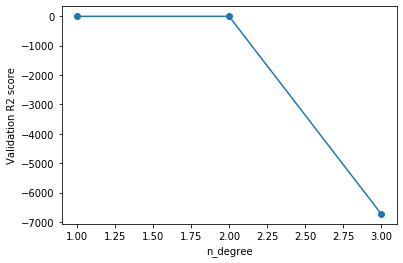


Lasso polynomial regressor


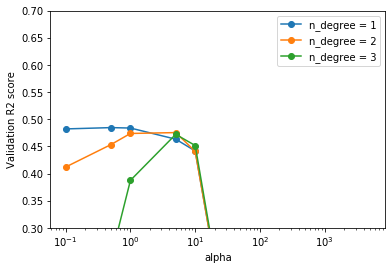


Ridge polynomial regressor


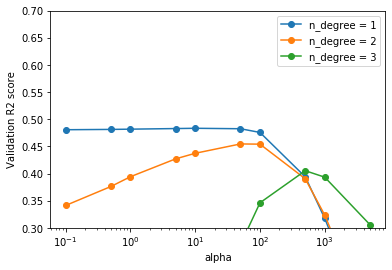

In [99]:
print('Polynomial regressor (unregularized)')
plt.plot(degrees,clf_linear.cv_results_['mean_test_score'],'o-')
plt.xlabel('n_degree')
plt.ylabel('Validation R2 score')
plt.show()

print('\nLasso polynomial regressor')
plot_cv_results(clf_lasso,'n_degree',degrees,'alpha')

print('\nRidge polynomial regressor')
plot_cv_results(clf_ridge,'n_degree',degrees,'alpha')

In the graphs we can see that the unregularized polynomial regressor performs very poorly for higher degrees, due to overfitting.

The Lasso polynomial regressor performs well for values of $\alpha$ around 1. Nevertheless, the best performance is still obtained for degree 1 (linear features). And we obtain a similar result for the Ridge regressor, at higher values of $\alpha$.

#### Conclusions about polynomial regression
First of all, higher polynomial degrees greatly increase the computational cost. Actually, for degree 4 and higher the running time was getting remarkably long. Moreover, in this case degree 2 and 3 proved to be not better than linear features, so it does not seem worth to go for higher polynomial orders.

An increase in the polynomial degree greatly increases the number of features (from 10 linear features to 64 at degree 2, 285 at degree 3, 1000 at degree 4...). Therefore, the chances of overfitting greatly increase. In the unregularized polynomial regressor, the score greatly decreases for degree 3. This is very reasonable, as we are using 285 polynomial features (therefore 285+1 weights) to predict 353 data points. Therefore, overfitting is very likely to occur.

Thus, it is necessary to use regularized linear models when using higher order polynomials, in order to avoid overfitting. Also, in the graphs it can be seen that values of $\alpha$ have to be at least around the order of magnitude of 1, in order to yield good results. This makes sense, as an small $\alpha$ means that regularization has small weight. And a very large $\alpha$ sets most weights to zero and provides bad performance, as the regularization term has more influence than the error in the regression outcome.

Additionally, it is remarkable than for small $\alpha$ and higher degrees, the computation time largely increases, as more iterations are needed for the regressors to converge.

### Final greedy search
Finally, we will perform a greedy search including the type of regressor as a parameter, and obtain the best performing one. In this search, we will be including what we have learnt in the previous section:
* Regularized regressors perform poorly with low $\alpha$, and take a lot of computation. Therefore, small values of $\alpha$ will not be investigated, and more values around and higher of 1 will be investigated.

* Higher order polynomials take more computational time and do not perform well. Therefore, we will restrict this search to degree 3 and lower.

**Note**: the ratio parameter of ElasticNet is not to be cross-validated. It is 0.5 by default, giving the same relevance to L1 and L2 regularization. The reason for not including this hyperparameter in the CV is that, when performing a greedy search over all possible combinations of regressor, alpha, and ratio, GridSearchCV would compute different models for different ratios also for the Linear, Lasso and Ridge regressor, which do not depend on such parameter. Therefore, we would be making redundant computations and wasting too much computational power.

In [82]:
rang_alpha = [0.1, 0.3, 0.5, 1, 3, 5, 10, 30, 50, 100, 300, 500, 1000, 5000]
degrees = np.arange(3) + 1
regressors = ['linear','Lasso','Ridge','ElasticNet']
parameters = {'alpha':rang_alpha , 'n_degree':degrees,'regressor':regressors}
CV = 10

clf = GridSearchCV(PolyReg(),parameters,iid=False,cv=CV,scoring='r2')
clf.fit(X_train,Y_train)
regressor = clf.best_estimator_
print('The best estimator is the '+clf.best_params_['regressor']+' regressor with polynomial degree %d' %(clf.best_params_['n_degree']))
print('Train R2 score: %f' %regressor.score(X_train,Y_train))
print('Test R2 score: %f' %regressor.score(X_test,Y_test))

The best estimator is the linear regressor with polynomial degree 1
Train R2 score: 0.528295
Test R2 score: 0.437303


The linear regressor (degree 1) is finally the best performer. The polynomial approach has yielded no useful results, and this is probably due to the absence of higher-order "good" features, that is, non-linear combinations of the features that good predictors.

Also, the unregularized linear regressor has shown better performance than the regularized ones. However, as we could see at the end of subsection 2.2. , results for all linear models (both regularized and unregularized) were extremely similar, and the fact that the unregularized one provides the slightly better performance is of little significance. Also, this similarity in all results actually may be pointing that regularization is playing little role in the regularized ones, and that regularization is not much needed in this problem, as the number of weigths is much smaller than the number of data points (in the linear case, with degree 1, of course).

## 3. Study of feature relevance and feature selection

In this last section, using different criteria, you have to analyze the relevance of the input features. Thus, you will have to find a subset with the $D'$ most relevant features and, using this subset of features, analyze the final performance of a regressor (for the sake of simplicity, consider a linear ridge regressor as final regressor).

To analyze the feature importances or relevances, you can use the following criteria:

1. **Relevance ranking based on the validation error**: if there were $D$ input features, we could try to train $D$ regressors where each regressor uses one (and only one) different input feature. According to the final perfomance of each regressor (evaluated on a validation set or with a CV proccess), we could rank the features (the most relevant feature is the one providing the lowest error). Using this ranking, we can select the $D'$ most relevant features as the $D'$ top-ranked ones. Note that this scheme only analyzes the isolated relevance of each feature to predict the output; so, it is said that this approach is *univariate*.

 <img src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/ML/Regression/FeatureRanking.png" width="90%" > 


2. **Greedy search based on the validation error**: approach (1) has the disadvantage of not taking into account relationships between features. For instance, method (1) would not realize that two features can be rendundant or that a feature, that is useless by itself, can be very useful combined with another feature. To overcome this drawback, we should have to analyze subsets of features; however, exploring all possible subsets  is usually computationally unflexible (there are $2^D$ combinations!!!!); so a greedy search (fordward or backward) is usually prefered:

  2.1 *Fordward search*: It starts with an empty set and, iteratively, adds new features according to a relevance criterion (in this case, minimum validation MSE).

  <img src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/ML/Regression/Fig_Forward_search.png" width="48%" > 

  2.2 *Backward search*: It starts considering all the features and, iteratively, removes features according to a relevance criterion (in this case, minimum validation MSE).

  <img src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/ML/Regression/Fig_Backward_search.png" width="48%" > 

3. **Ridge linear regression with a prunning**: We know that the L2 regularization limits the magnitude of the weight vector to avoid overfitting problems, but these weigths do not become to null. However, in a linear model, *the weight magnitude can be an indicative of the feature relevance* and, unlike approach (1), all features are analyzed at the same time (*multivariate approach*). Use the weigth magnitude to generate a ranking of features and, later, use this ranking to select the $D'$ most relevant features.

4. **Lasso linear regression**: In this case, the L1 penalty allows us to directly eliminate some of the input features. Explore different values of the regularization parameter $\lambda$ to get a sequence of selected feature sets (from a single feature to all features).


5. **Elastic-net linear regression**: This last approach combines L1 and L2 regularizations, thus including the advantages of both methods. Varying adequately their regularization parameters, create a sequence of feature selection subsets. 



Final comments:

* Due to part of the feature selection process involves selecting the optimum number of features, to avoid additional complexity (having to validate this number), you can analyze the different methods by exploring the curves of MSE vs. number of selected features ($D'$).

* It is not necessary to apply all these methods to complete this notebook (you can choose, at least, three of them). In fact, the implementation of greedy search approaches require an advanced knowledge of Python; so take this into account when you design your notebook solution.

* **Please, analyze in detail the different results, pointing out the advantages/disadvantages of each feature selection scheme**. Think about the behaviour of the different criteria in cases where a feature is irrelevant or there are redundant features. Additional experiments helping you to support any of your conclusions will be welcome.

In [14]:
## 3. Feature selection 

# Include your code here (create as many cells as you need)

### Method 4 : Feature selection with Lasso linear regression
With Lasso (L1) regularization, some of the weigths usually tend to zero. Therefore, it can be used for feature selection.

In [91]:
rang_alpha = [0.5,1,5,10,50,100] # From the polynomial regression section, this is the alpha range in which best results are obtained

weights = np.zeros((len(rang_alpha),X_train.shape[1]))
threshold = 1
features_selected = np.zeros((len(rang_alpha),X_train.shape[1]))

plt.plot()
for (i,a) in enumerate(rang_alpha):
    lasso = ln.Lasso(fit_intercept=True,alpha=a).fit(X_train,Y_train)
    weights[i,:] = lasso.coef_
    features_selected[i,:] = lasso.coef_ > threshold

print(weights)

[[ -0.          -7.28746605  24.36440572  19.19490968 -10.58748369
   -0.          -5.51221874   5.31505431  25.32981978   0.        ]
 [ -0.          -6.35526041  24.15573989  18.55148973  -7.59728952
   -0.          -7.94065565   1.68550057  24.81179037   0.        ]
 [  0.          -0.          23.13883561  14.44959477  -0.
   -0.          -6.23223441   0.          20.17985336   0.        ]
 [  0.          -0.          21.57504292  11.38165562  -0.
   -0.          -3.08996085   0.          18.46630257   0.        ]
 [  0.           0.           0.           0.           0.
    0.          -0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.          -0.           0.           0.           0.        ]]
